# Analysis of Daily Mail Headlines
Author: Adil Khan

This notebook analyses the headlines listed in the Daily Mail online archives. 

The goal is to create a dash web app that will:

1. Track sentiment. The user will be able to interactively select which genre(s) to analyse and adjust the frenquency of analysis.
2. Generate word clouds for each genre. The user will be able to adjust the genre(s), the time period and the number of words in the word cloud.


Further avenues for analysis:

1. Use fbprophet to detect trends and make predictions.
2. Do changepoints occur at key political/social momemnts, e.g. Brexit, US election?
3. Parralelize fbprophet using https://github.com/PierreGe/fbprophet-headless)
4. More wordcloud masks options

In [153]:
import pandas as pd
import numpy as np
import datetime    
from matplotlib import pyplot as plt
import pprint
import plotly.graph_objs as go
import nltk
import wordcloud
from PIL import Image, ImageFont, ImageDraw
import base64
import random

## Load Data

In [174]:
#Choose range from 2013 to 2018 to analyse
fileList = [('DailyMail%s.csv' %str(i)) for i in range(2013,2018+1)]

#Create a list of dataframes
dfList = [pd.read_csv(fileList[i],
                      encoding='latin1',
                      names = ['YearID', 'Date', 'Genre', 'Sentiment', 'Title'])
          for i in range(len(fileList))]

#WARNING: CHANGE 'YearID' datatype to int

#Concatenate
df=pd.concat(dfList)

#Drop any null rows because there are plenty of records
df=df.dropna()

#Format datatype
df['Sentiment']=pd.to_numeric(df['Sentiment'])
df['YearID']=df['YearID'].astype(int)

/Users/Adil/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



## Handle multiple date formats


Two data formats are present: 'Y/%m/%d'  &   '%d/%m/%y'

Invalid dates are present, e.g. 30-02-2017




In [ ]:
#Test to see if each date can be converted. If neither format works, append index to invalid.

invalid=[]

for i in range(len(df['Date'])):
    try:
        pd.to_datetime(df['Date'].iloc[i],format='%Y-%m-%d')
    except ValueError:
        try:
            pd.to_datetime(df['Date'].iloc[i],format='%d/%m/%y')
        except ValueError:
            invalid.append(i)
            
#Take indices that are not in invalid

valid = [i for i in range(len(df.index)) if i not in invalid]
df=df.iloc[valid]

#Convert to datetime and set to index

df['ds']=pd.to_datetime(df['Date'])
df=df.set_index(df.ds)
df.index.name='dt'

#Draw a sample
df.sample(10)

In [176]:
for i in range(10):
    loc = random.randint(0,len(df))
    print('Date:\t\t'+df.iloc[loc].Date)
    print('Genre:\t\t'+df.iloc[loc].Genre)
    print('Sentiment:\t'+str(df.iloc[loc].Sentiment))
    print('Headline:\t'+df.iloc[loc].Title,end='\n\n')


Date:		12/05/18
Genre:		wires
Sentiment:	-0.5267
Headline:	1 hurt in propane tank explosion at Chicago's Soldier Field

Date:		21/02/17
Genre:		tvshowbiz
Sentiment:	-0.4574
Headline:	'I've never met such a self-obsessed, repugnant, obnoxious little monster!' I'm A Celebrity star Ash Pollard slams Keira Maguire for saying she doesnäó»t want to do any more trials

Date:		2014-10-14
Genre:		wires
Sentiment:	0.2023
Headline:	J&J sales top forecast, helped by drug for hepatitis C

Date:		19/04/18
Genre:		wires
Sentiment:	0.0
Headline:	In Pictures: Meghan and Harry cosy up one month before royal wedding

Date:		2015-11-06
Genre:		sport
Sentiment:	0.743
Headline:	Manchester United trio head list of Premier League youngsters vying for 2015 Golden Boy award as shortlist is announced 

Date:		2015-02-06
Genre:		wires
Sentiment:	0.0772
Headline:	Uruguay's Lodeiro not afraid to wear weighty Boca number 10

Date:		2016-12-03
Genre:		wires
Sentiment:	0.0
Headline:	Ex-German POW gives legacy to Scott

## Save/read dataframe

In [8]:
#Save clean data to file
def save():
    filename='dmdata.csv'
    df.to_csv(filename)

#save()

In [175]:
#Read data from file
def read():
    filename='dmdata.csv'
    global df
    df=pd.read_csv(filename)
    #df=df.drop(columns=['Unnamed: 0'])
    df['dt']=pd.to_datetime(df['dt'])
    df['ds']=pd.to_datetime(df['ds'])
    df.index=df.dt
    df=df.drop(columns=['dt'])
read()

## Group by genre and date. Calculate the mean sentiment in each group

In [4]:
#Group by genre and date
groups = df.groupby(['Genre','ds'])

#Create a list of genres
GenreList=list(set([name[0] for name,group in groups]))

#Create indices
genres = [name[0] for name, group in groups]
dates = [name[1] for name, group in groups]

#Calculate mean sentiment for each certain genre and for each date
meanSent = [group.Sentiment.mean() for name, group in groups]

#Create a new dataframe    
df2 = pd.DataFrame({'Daily_Sentiment':meanSent},index= [genres,dates])
df2.index.names = ['Genre','Date']
df2.head(20)

Daily_Sentiment
Genre     Date                       
auhome    2014-07-04           0.2714
          2014-07-09           0.6946
          2014-07-28           0.4389
          2014-08-12           0.7158
          2014-08-25          -0.2263
          2014-09-01           0.2960
          2014-10-13           0.8573
          2014-11-03          -0.5106
          2014-11-20           0.0000
          2014-12-10           0.8834
          2014-12-13           0.7263
          2014-12-16           0.7351
          2015-01-07           0.5940
          2015-04-29          -0.3612
          2015-05-03          -0.7003
          2016-02-08          -0.4493
aushowbiz 2014-07-06          -0.6621
          2014-07-07          -0.7506
          2014-08-04           0.6588
          2014-08-06           0.0772

## Order genres by data quality

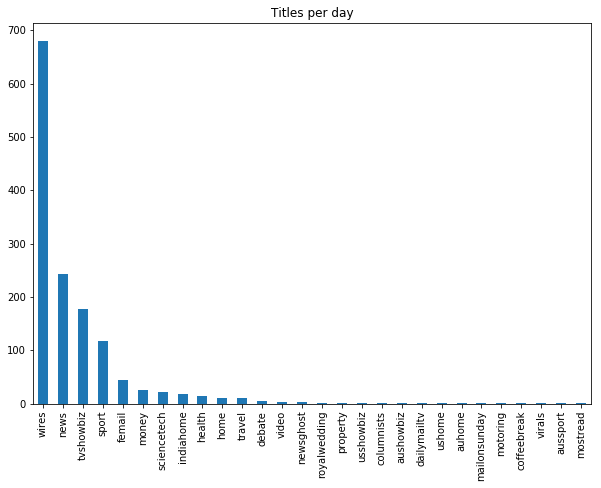

In [180]:
#Data quality is equivalent to the total number of articles divided by 
# the number of days the genre appears.

titlesPerDay = [ len(df[df.Genre==genre]) / len(df2.loc[genre]) for genre in GenreList]
quality = pd.DataFrame({'TitlesPerDay':titlesPerDay},index = GenreList).sort_values(by='TitlesPerDay',ascending=False)
quality.plot.bar(title = 'Titles per day',legend=False,figsize = (10,7));

## Most common words

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords+=[' ','','-','the','could', "'i", '(and', 'new','says', '\x89ûò', '1:']

#Function takes a list of titles and returns top n words

titles = list(df[df.Genre=='sport'].iloc[:].Title)

def topwords(titles, n=10):

    #join titles together
    text = ' '.join(list(titles))

    #Split them into a list of words
    text = text.split(' ')

    #Filter stopwords
    text = [word.lower() for word in text if word.lower() not in stopwords]

    #Frequency distribution
    return nltk.FreqDist(text).most_common(n)

## Wordclouds

Frequency distribution for sports
[('manchester', 24353),
 ('league', 24251),
 ('united', 18118),
 ('cup', 17355),
 ('england', 16769),
 ('world', 14098),
 ('city', 13342),
 ('premier', 13206),
 ('boss', 12880),
 ('chelsea', 11972)]

Wordcloud for sports


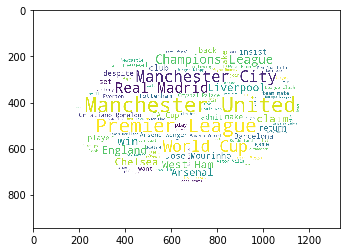

In [7]:
titles =  df[df.Genre=='sport'].iloc[:].Title
text = ' '.join(list(titles))

#Generate a wordcloud object
wc=wordcloud.WordCloud(stopwords = stopwords,
                       background_color='white',
                       max_words=100,
                       mask=np.array(Image.open('cloud.png')))

#Provide space separated list of words to wc object
wc.generate(text)

#Print frequency distribution
print('Frequency distribution for sports')
pprint.pprint(topwords(titles,10))

#Display word cloud
print('\nWordcloud for sports')
plt.imshow(wc)
plt.show()

## Build web app using dash

In [8]:
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
    
options = [{'label': i, 'value': i} for i in quality.index]

image_filename = '/Users/Adil/Documents/Data Science/NLTK/wc.png'


app = dash.Dash()



app.layout = html.Div([
    
    html.H1(
        'Does the Daily Mail have feelings?'
    ),
    
    html.Div(
        'Sentiment analysis of a headline provides an emotional score from -1 to +1,\
        where -1 indicates a negative response and +1 indicates a positive response.'
    ),
    
    dcc.Dropdown(
        id='my-dropdown1',
        options=options,
        multi=True,
        placeholder='Start select one or more genres.'
    ),
    
    dcc.RadioItems(
        id='my-radio', 
        options=[
            {'label':'Daily', 'value':'D'},
            {'label':'Weekly', 'value':'W'},
            {'label':'Bi-monthly', 'value':'SM'},
            {'label':'Monthly', 'value':'M'},
            {'label':'Quarterly', 'value':'Q'},
            {'label':'Yearly', 'value':'A'}
                   ],
        value='Q'
    ),
    html.Div(
        id='my-graph1'),
    
    html.H3(
        'Word Cloud Generator'
    ),
    
    dcc.Dropdown(
        id='my-dropdown2',
        options= [{'label': str(i), 'value': i} for i in range(2013,2019)],
        multi=True
    ),
    
    dcc.Input(
        id='my-number', 
        type = 'number', 
    ),
        
    html.Img(
        id='word-cloud'
    )

])



@app.callback(
    Output(component_id='my-graph1', component_property='children'),
    [Input(component_id='my-dropdown1', component_property='value'),
    Input(component_id='my-radio', component_property='value')]
)

def update_graph(selected_dropdown_value, frequency):

    try:
        data=[go.Scatter(x=df2.loc[i].resample(frequency).mean().index,
                         y=df2.loc[i].resample(frequency).mean().Daily_Sentiment,
                         name=str(i)) for i in selected_dropdown_value]
    
        return     dcc.Graph(id='outgraph1',
            figure=go.Figure(data=data,
            layout=go.Layout(showlegend=True)
                     ))
    except TypeError:
        return None #dcc.Graph(id='outgraph1')

    
@app.callback(
    Output(component_id='word-cloud', component_property='src'),
    [Input(component_id='my-dropdown1', component_property='value'),
    Input(component_id='my-dropdown2', component_property='value'),
    Input(component_id='my-number', component_property='value')]
)

def update_word_cloud(genre,year,number):
    
    wc=wordcloud.WordCloud(stopwords = stopwords,
                       background_color='white',
                       max_words=number,
                       mask=np.array(Image.open('cloud.png')))
    try:
        titles = list(df[(df.ds.dt.year.isin(year)) & (df.Genre.isin(genre))].Title)
        join = ' '.join(titles)      
        wc.generate(join)
        wc.to_file(image_filename)
        encoded_image = base64.b64encode(open(image_filename, 'rb').read())
        return 'data:image/png;base64,{}'.format(encoded_image.decode())
    except TypeError:
        return None

    
    
if __name__ == '__main__':
    app.run_server(port = 8052)

 * Running on http://127.0.0.1:8052/ (Press CTRL+C to quit)
127.0.0.1 - - [30/Aug/2018 12:09:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Aug/2018 12:09:57] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [30/Aug/2018 12:09:57] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [30/Aug/2018 12:09:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Aug/2018 12:09:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Aug/2018 12:09:58] "GET /favicon.ico HTTP/1.1" 200 -
127.0.0.1 - - [30/Aug/2018 12:10:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Aug/2018 12:10:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Aug/2018 12:10:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Aug/2018 12:10:07] "POST /_dash-update-component HTTP/1.1" 200 -


## Insights


In [145]:
   
import plotly.plotly as py
import plotly.graph_objs as go

def trace(genres, frequency):

    trace=[go.Scatter(x=df2.loc[i].resample(frequency).mean().index,
                     y=df2.loc[i].resample(frequency).mean().Daily_Sentiment,
                     name=str(i),
                     mode='line')
           for i in genres]
 
    return py.iplot(trace)

def generate_word_cloud(genre,year,number):
    
    wc=wordcloud.WordCloud(stopwords = stopwords,
                       background_color='white',
                       max_words=number,
                       mask=np.array(Image.open('cloud.png')))

    titles = list(df[(df.ds.dt.year.isin(year)) & (df.Genre.isin(genre))].Title)
    join = ' '.join(titles)      
    wc.generate(join)


    fig, ax = plt.subplots(figsize=(12,12))
    ax.axis('off')
    ax.imshow(wc)

In [142]:
(trace(['sport'],'Q'))


Sentiments about sport have been generarlly imporoving and positivity increases during the summer.

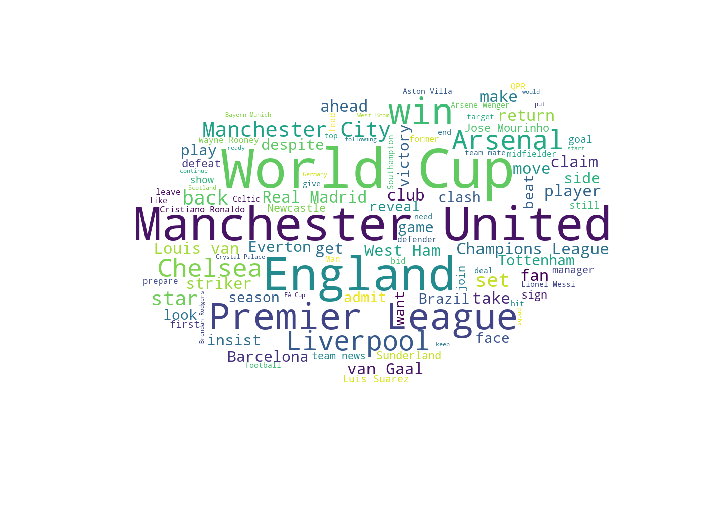

In [146]:
generate_word_cloud(['sport'],['2014'],100)

The world cup for sport in 2014 shows that the World Cup was a hot topic. Manchester United feature prominently and they of course won the Premier League in 2014.

In [129]:
trace(['femail'],'Y')

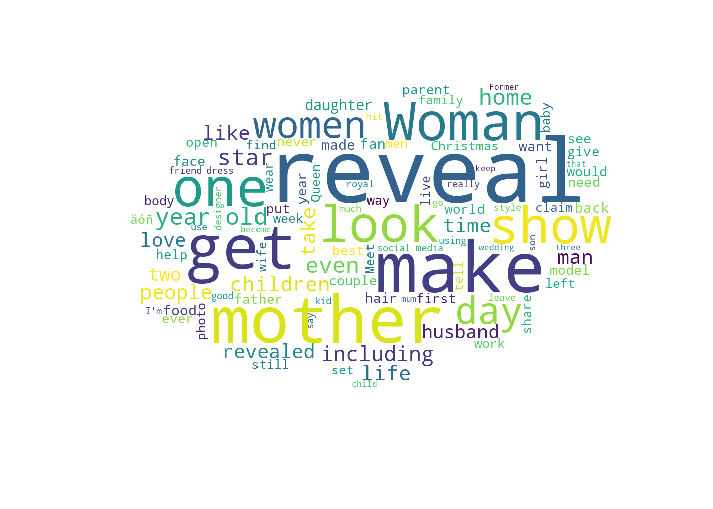

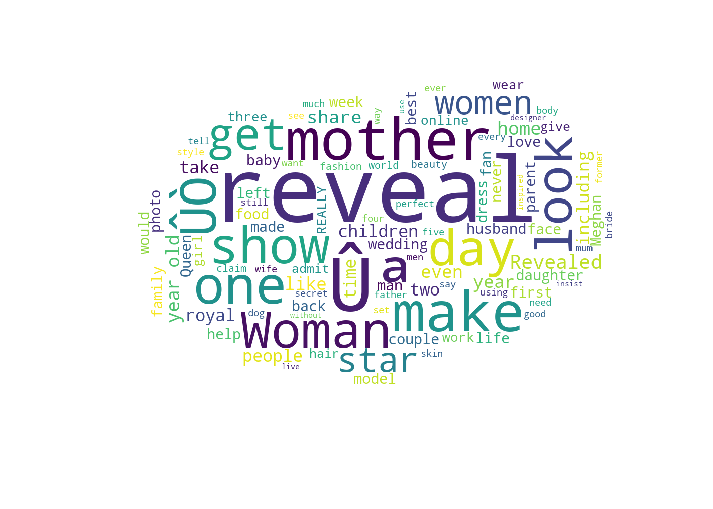

In [148]:
generate_word_cloud(['femail'],['2017'],100)
generate_word_cloud(['femail'],['2018'],100)

Women's sentiment was steadily increasing until early 2018. Why? The wordcloud reveals 'femail' topics of conversation in 2016 and 2018. Is there a difference?

In [181]:
trace(['news','money'],'Y')

News was already quite negative at -0.21 at the start of 2014 and has since declined further to -0.27. Negative outlook on global issues?<p>
In comparison, money has been fairly neutral, but took a dip in 2017 just as news became even worse. This indicates a relationship between economic stability and outlook on current affairs.

Plenty more to explore with Dash web apps!